# Import libraries and define variables

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

In [20]:
plotsDir = "plots/"
calculationsDir = "calculations/"
metrics = {'sb.bin' : 'Stereotipical bias',
           'acc_equality_diff.bin': 'Accuracy equality difference', 
           'acc_equality_ratio.bin': 'Accuracy equality ratio', 
           'disp_impact.bin': 'Disparate impact', 
           'equal_opp_diff.bin': 'Equal opportunity difference', 
           'equal_opp_ratio.bin': 'Equal opportunity ratio', 
           'neg_pred_parity_diff.bin': 'Negative predictive parity difference', 
           'neg_pred_parity_ratio.bin': 'Negative predictive parity ratio', 
           'pos_pred_parity_diff.bin': 'Positive predictive parity difference', 
           'pred_equality_diff.bin': 'Predictive equality difference', 
           'pred_equality_ratio.bin' :'Predictive equality ratio', 
           'pred_parity_ratio.bin': 'Positive predictive parity ratio', 
           'stat_parity.bin': 'Statistical parity'
          }

## Group Ratio distribution

In [3]:
with open(calculationsDir + "gr.bin", "rb") as f:
    gr = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = ["gr"])

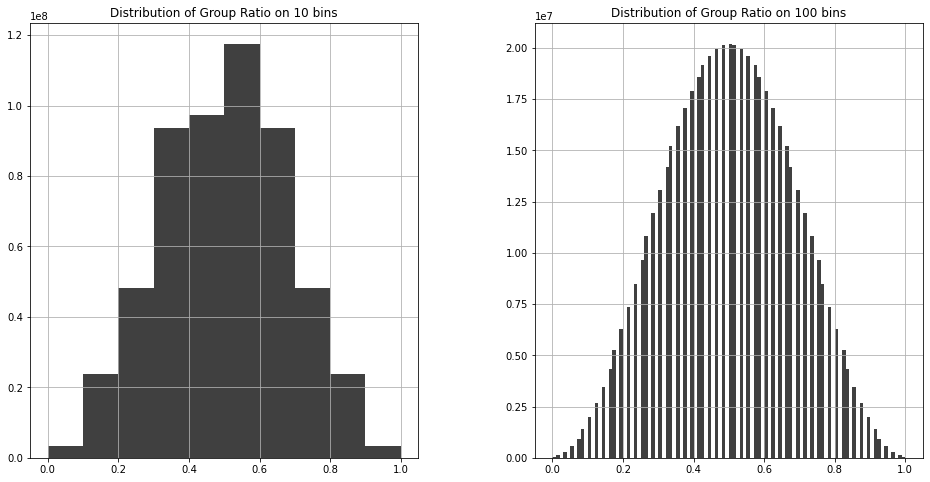

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

nBins = 10 
gr.hist(ax = ax[0], color = '#404040', bins = nBins)
ax[0].set_title(f"Distribution of Group Ratio on {nBins} bins")

nBins = 100
gr.hist(ax = ax[1], color = '#404040', bins = nBins)
ax[1].set_title(f"Distribution of Group Ratio on {nBins} bins")

fig.savefig(plotsDir + "GR.jpeg", dpi = 300)

## Imbalance Ratio distribution

In [5]:
with open(calculationsDir + "ir.bin", "rb") as f:
    ir = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = ["ir"])

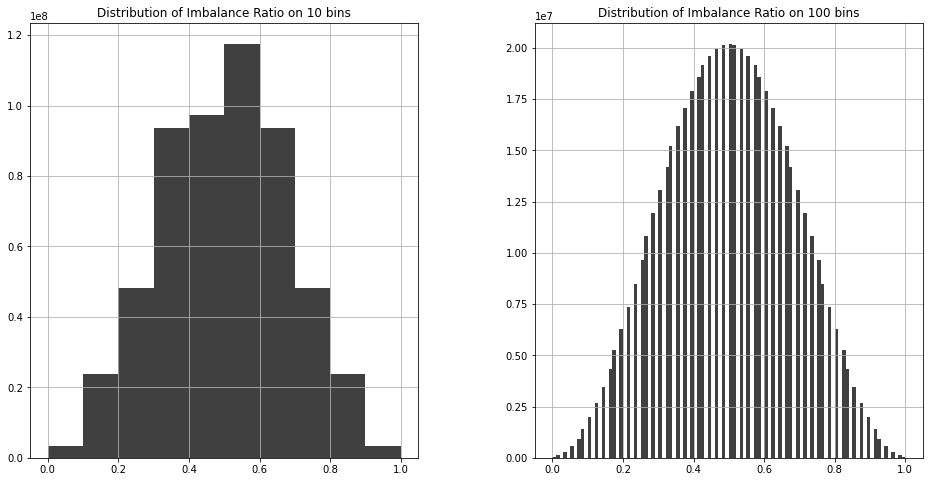

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

nBins = 10 
ir.hist(ax = ax[0], color = '#404040', bins = nBins)
ax[0].set_title(f"Distribution of Imbalance Ratio on {nBins} bins")

nBins = 100
ir.hist(ax = ax[1], color = '#404040', bins = nBins)
ax[1].set_title(f"Distribution of Imbalance Ratio on {nBins} bins")

fig.savefig(plotsDir + "IR.jpeg", dpi = 300)

## Metric disributions for selected IR and GR 

In [7]:
def getPlot(df, metric):
    fig = ggplot(df, aes(x = metric, fill = 'typeVal'))
    fig += geom_histogram(aes(y=after_stat('100*count/np.sum(count)')), bins = 100)
    fig += scale_fill_manual(values = {'NaN': '#ca0020', "not NaN": '#404040'}, guide = False)
    fig += facet_grid('ir~gr', labeller = 'label_both') 
    fig += scale_x_continuous(labels = lambda lst: [x if x != -1.5 else 'NaN' for x in lst])
    fig += theme_minimal() 
    fig += theme(figure_size = (16, 8)) 
    fig += ggtitle(f"{metric} for selected IR & GR")
    fig += ylab("Probability")
    return fig

In [8]:
ir_selected = [0.25, 0.5, 0.75]
gr_selected = [0.25, 0.5, 0.75]

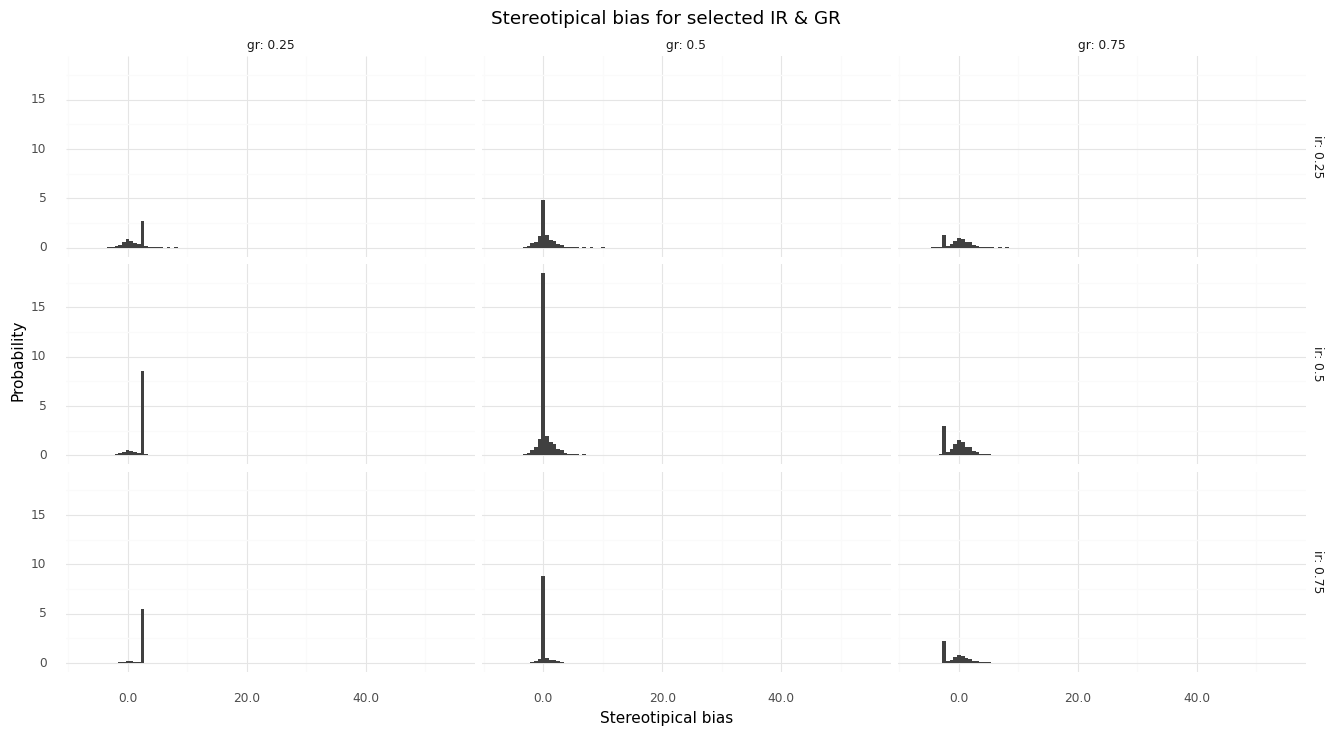

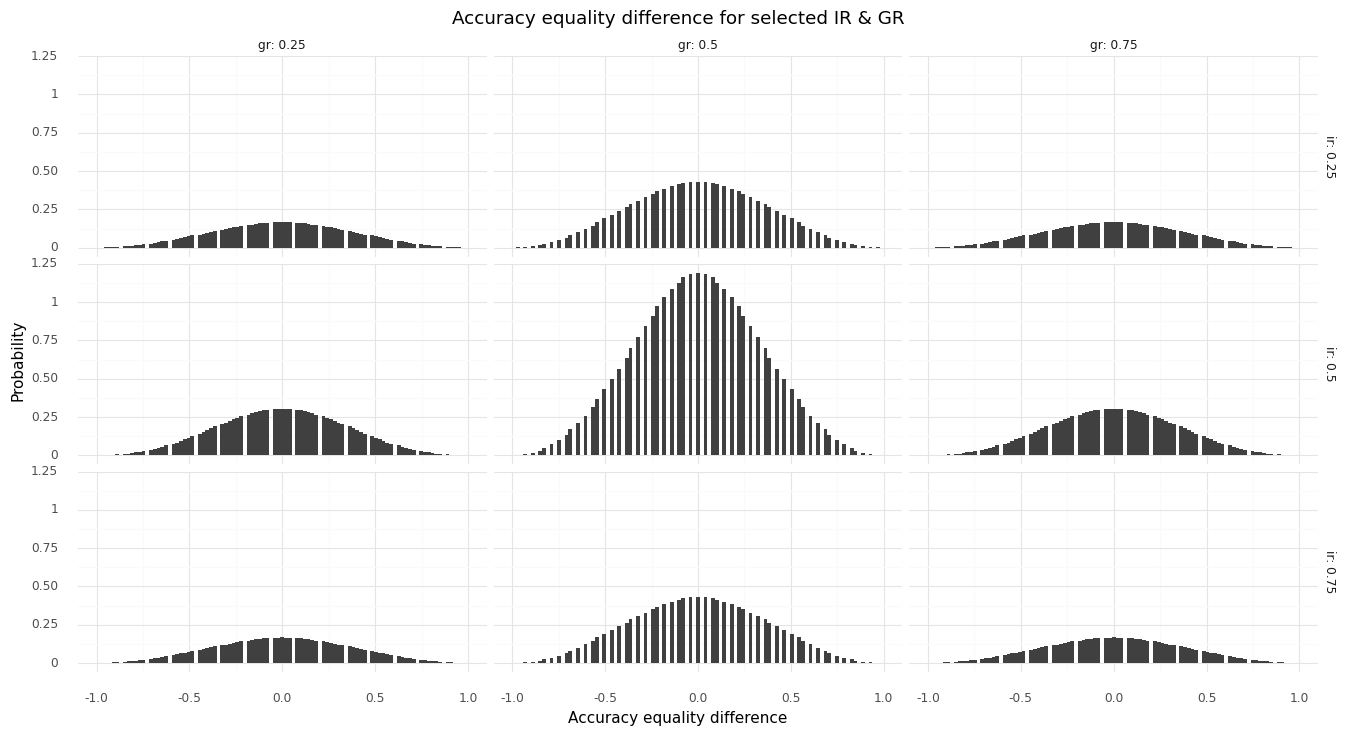

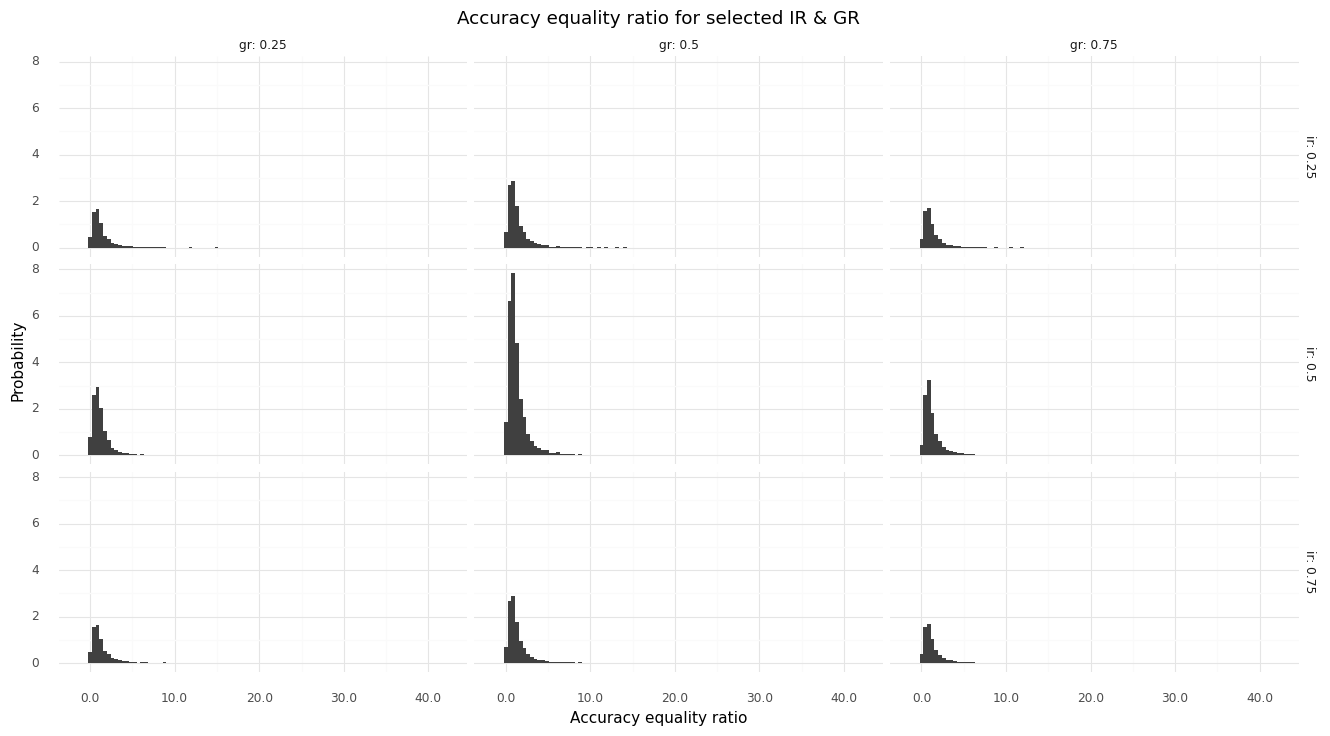

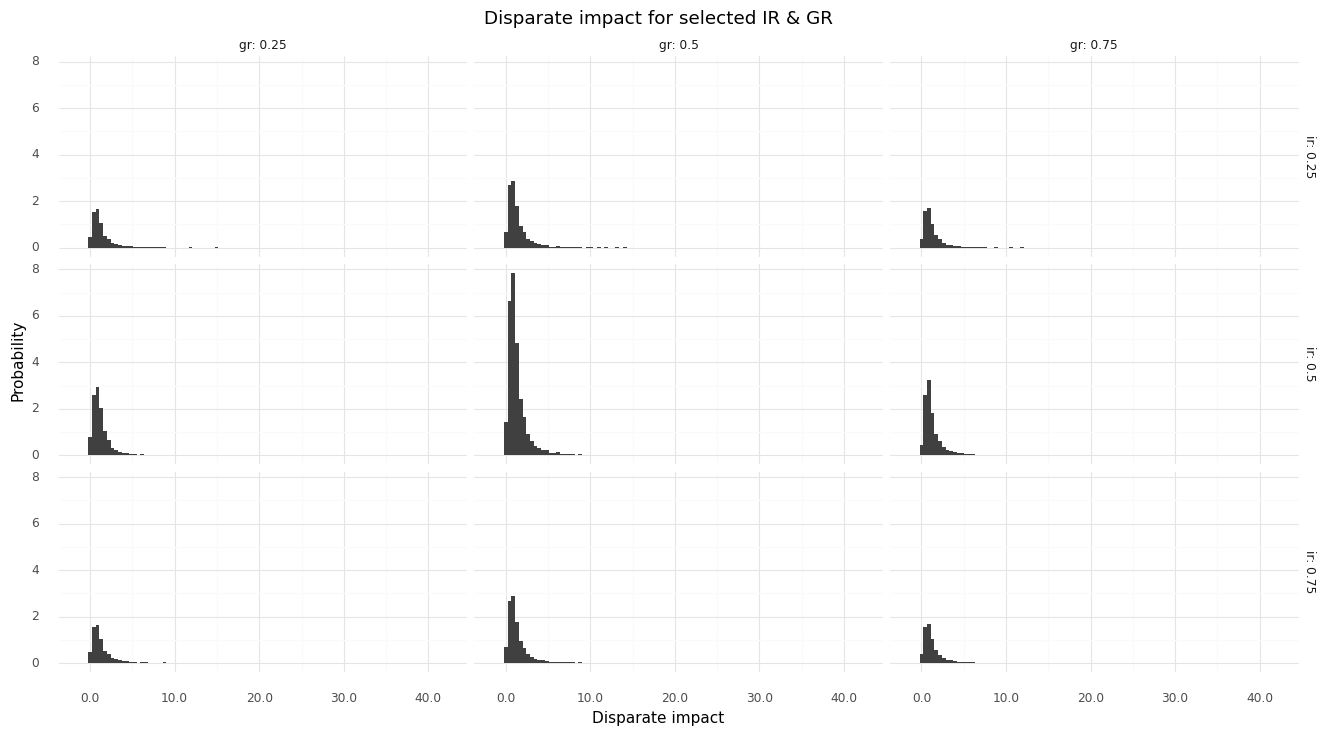

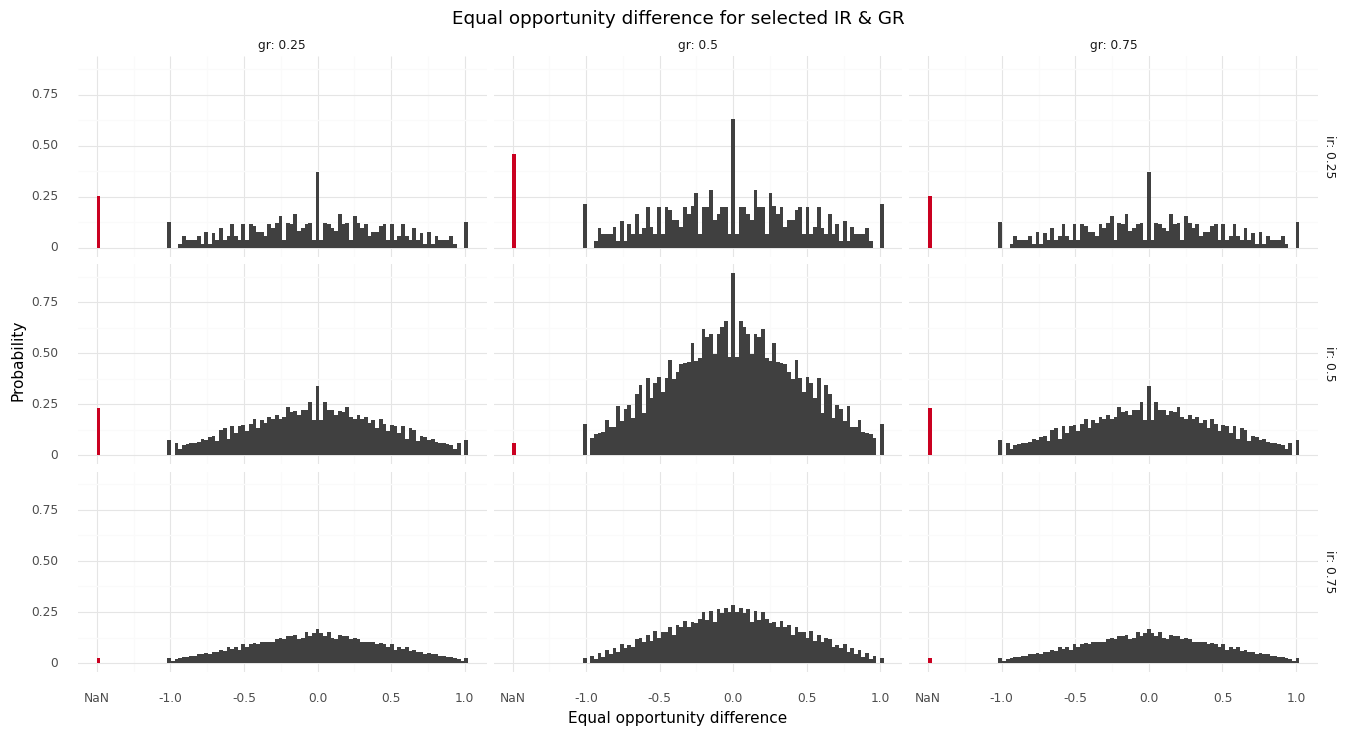

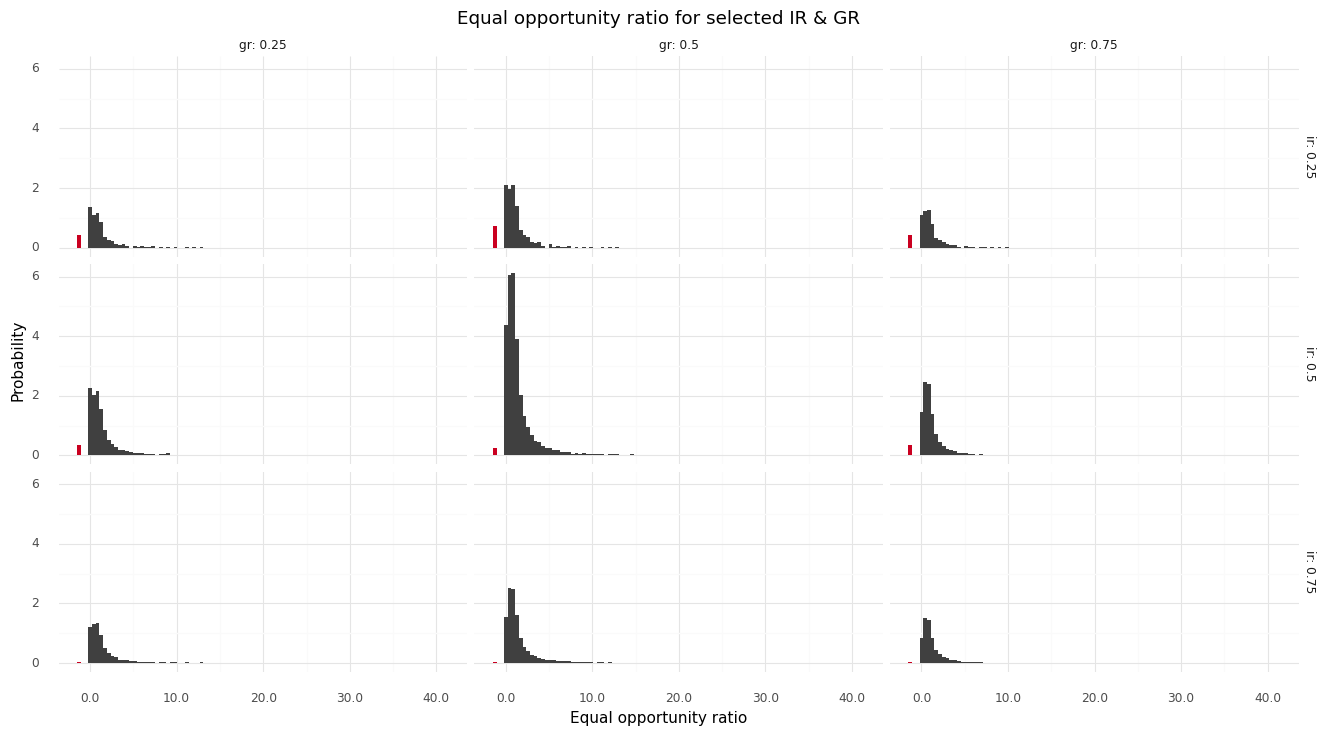

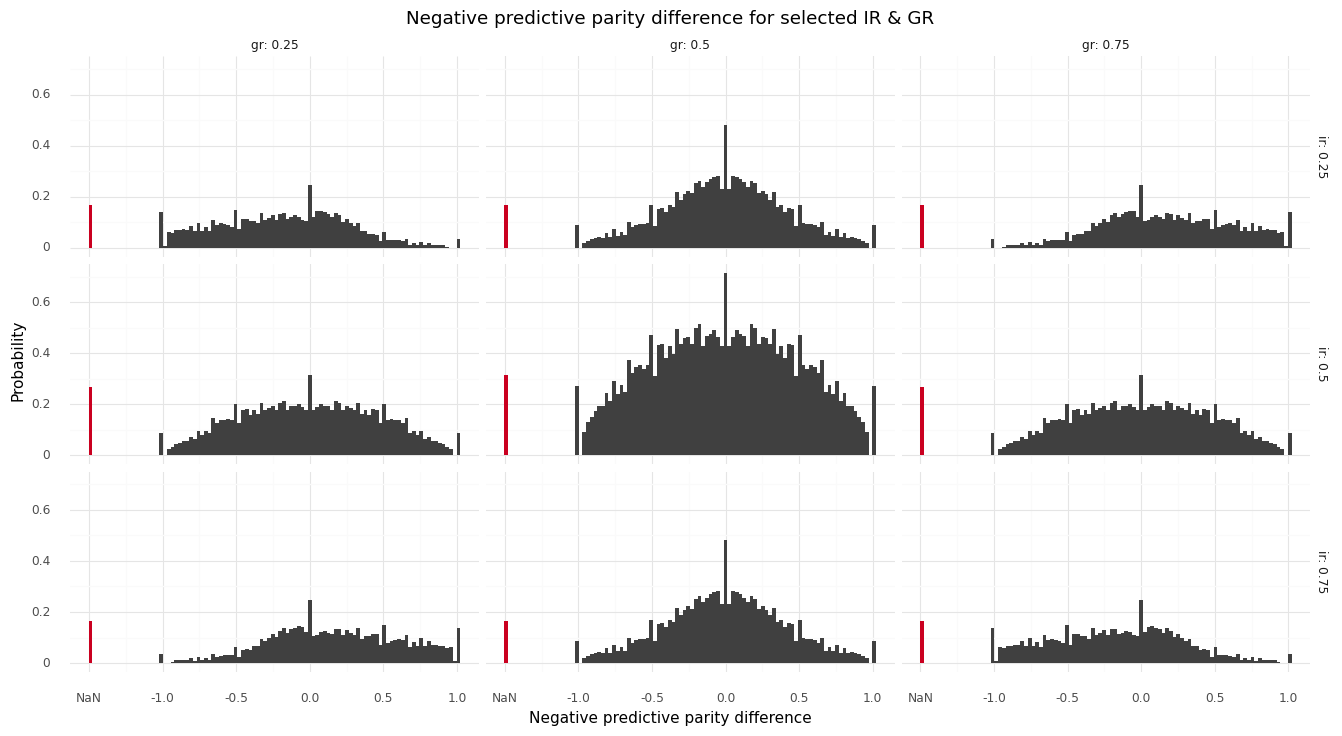

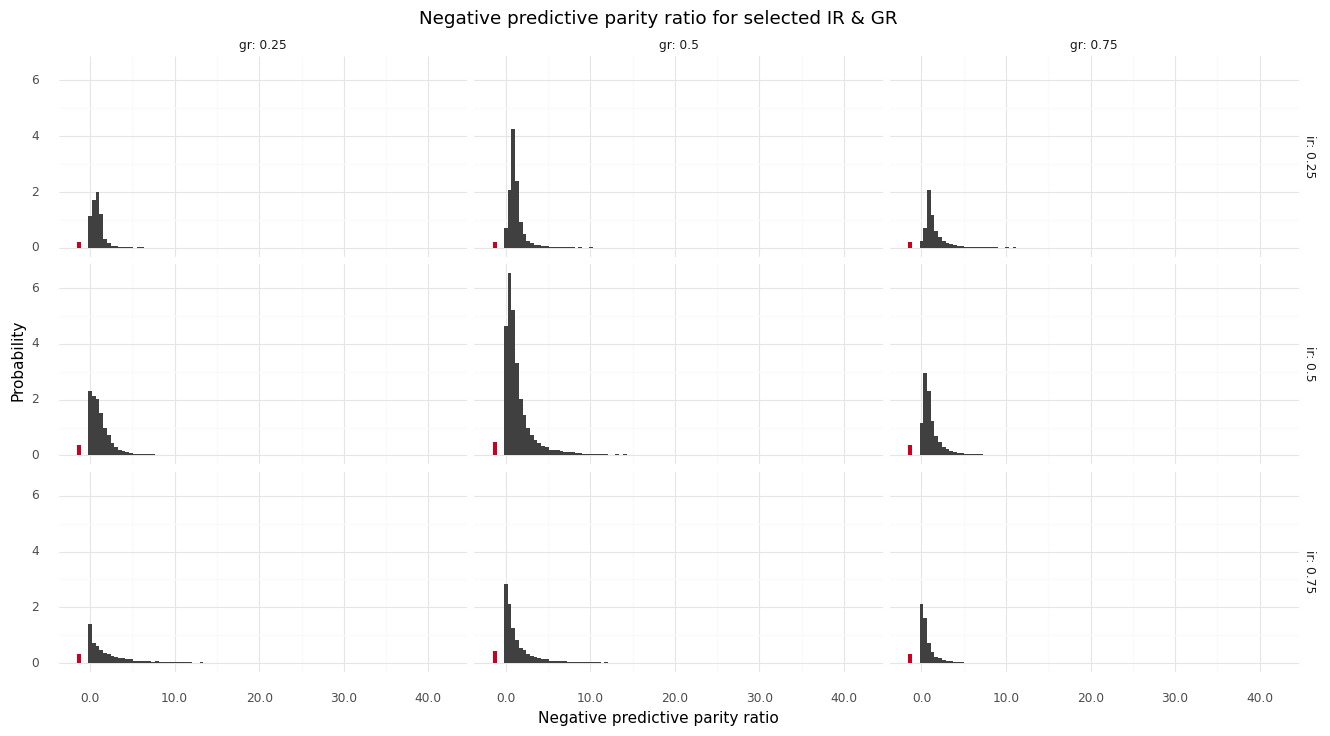

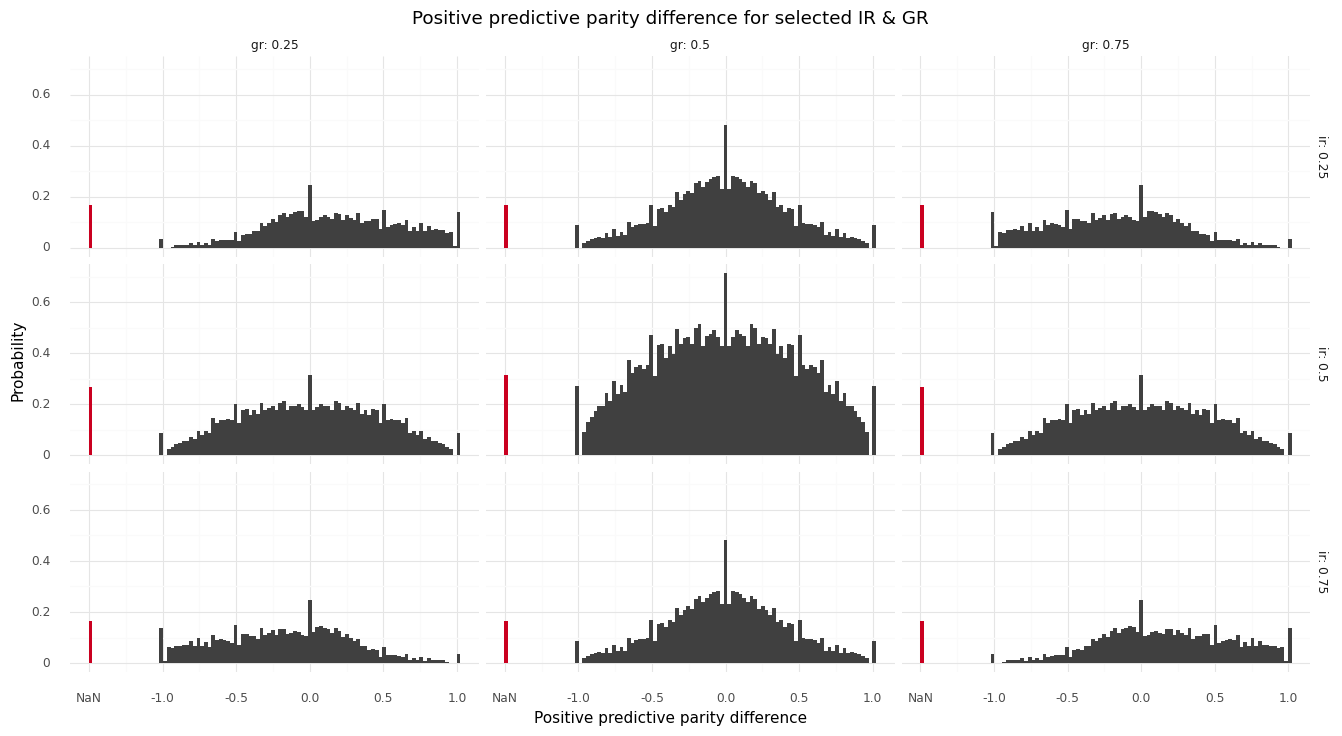

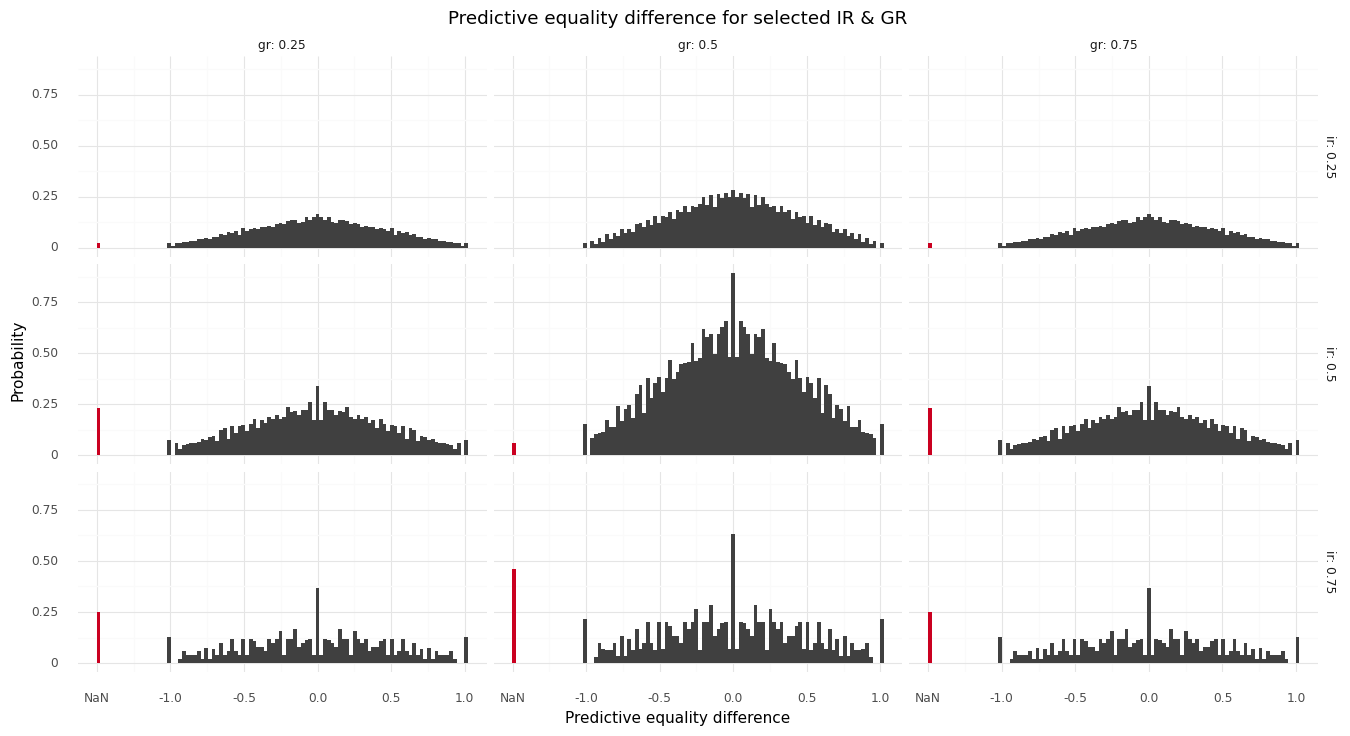

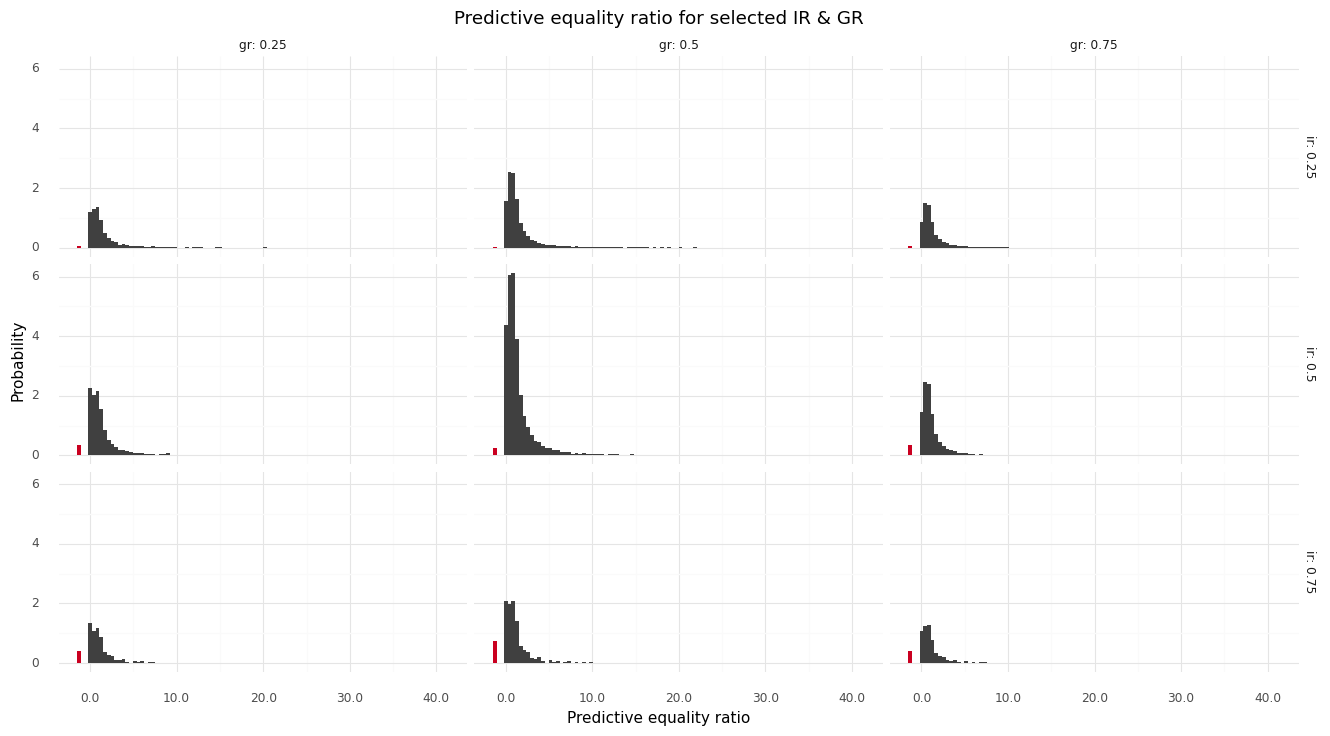

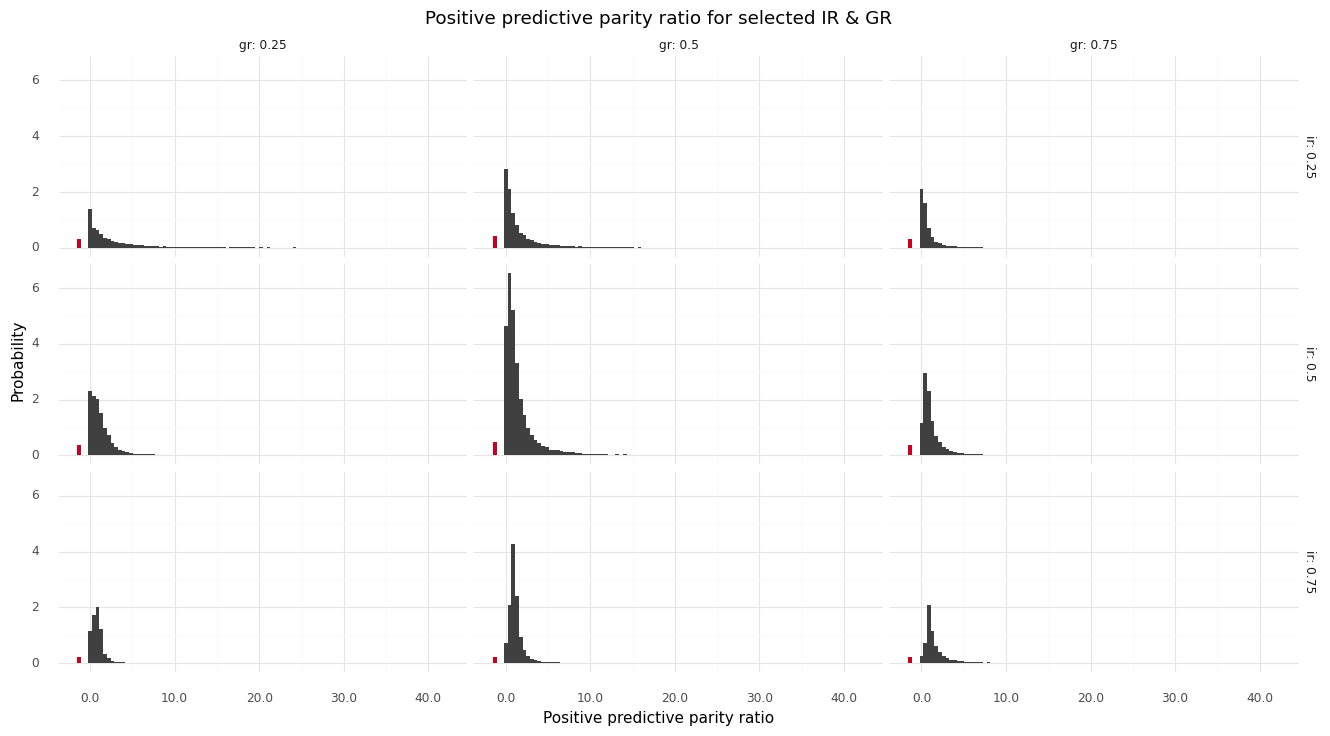

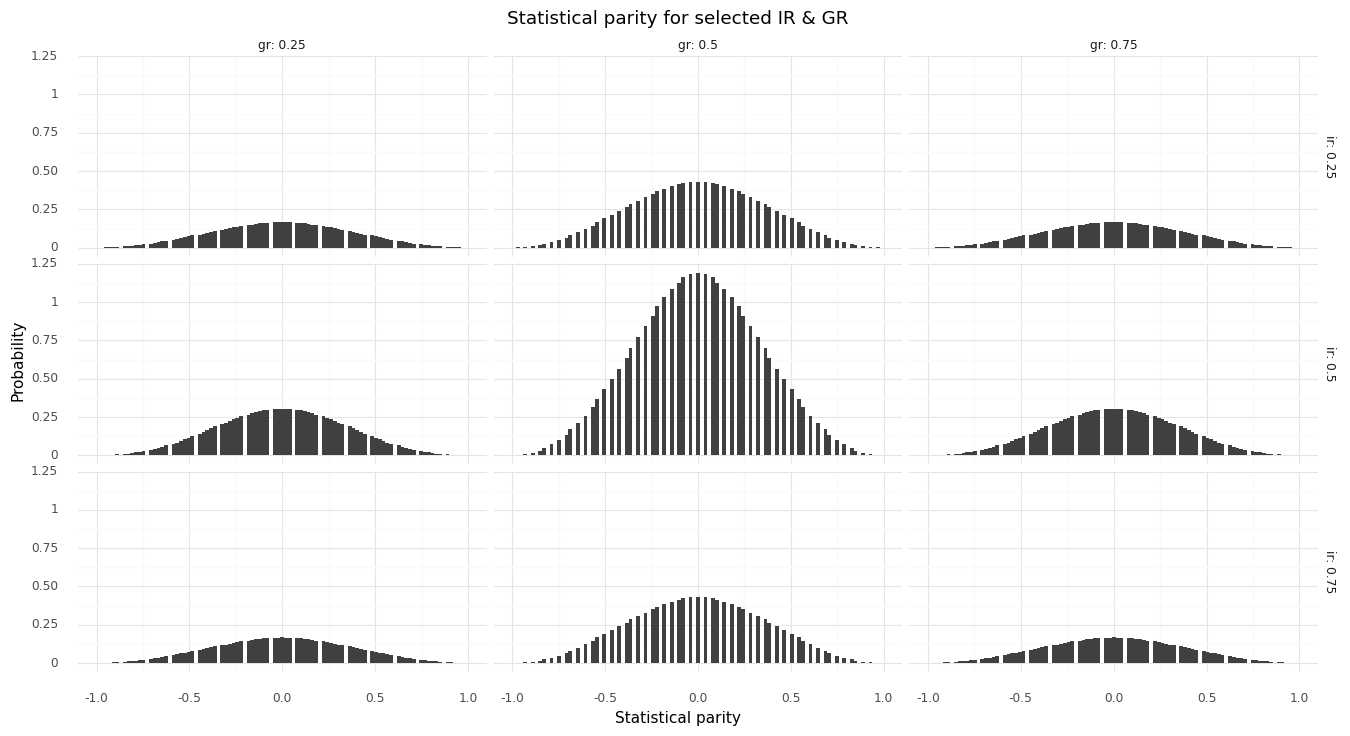

In [9]:
for metricFName in metrics:
    metricName = metrics[metricFName]
    with open(calculationsDir + metricFName, "rb") as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns = [metricName])
    df = pd.concat([gr, ir], axis = 1)
    df = pd.concat([df, metric], axis = 1)
    df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
    df.replace(np.nan, -1.5, inplace=True)
    df['typeVal'] = np.where(df[metricName] == -1.5, 'NaN', "not NaN")
    
    fig = getPlot(df, metricName)
    print(fig)
    fig.save(plotsDir + metricName + ".jpeg", width = 16, height = 8, dpi = 300)
    
    del metric
    del df
    gc.collect()

## Sonya plots

In [21]:
def melt_sonya(df, base_metric):
    temp = df.pop(base_metric)
    length = len(df.columns)
    df = pd.melt(df)
    df[base_metric] = list(temp) * length
    return df

In [22]:
def plot_sonya(df, base_metric):
    fig = ggplot(df, aes(x = base_metric, y = 'value', color = 'variable'))
    fig += geom_line()
    fig += scale_color_manual(values = {'Accuracy equality difference':'red',
                                        'Equal opportunity difference': 'green',
                                        'Predictive equality difference': 'blue',
                                        'Negative predictive parity difference': 'orange', 
                                        'Positive predictive parity difference': 'purple',
                                        'Statistical parity': 'black'})
    fig += theme_minimal() 
    fig += theme(figure_size = (8, 6))
    fig += ylab("Probability")
    fig += ggtitle(f"Proportion of perfect fairness")

    print(fig)
    return fig

In [23]:
df = pd.read_csv(calculationsDir + 'sonya_ir.csv')

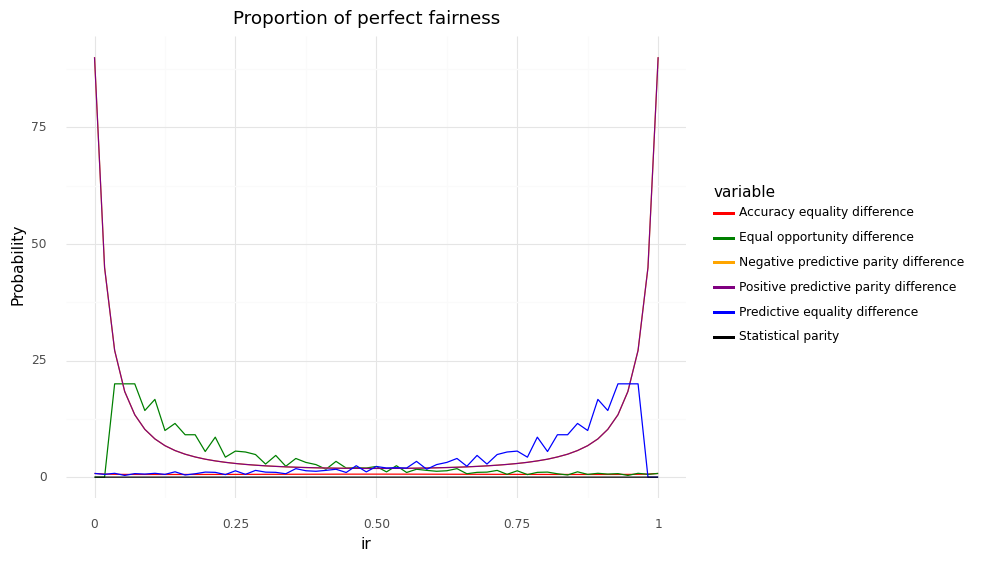

In [24]:
base_metric = 'ir'
fig = plot_sonya(melt_sonya(df.copy(), base_metric), base_metric)
fig.save(plotsDir + "sonya_" + base_metric + "1.jpeg", width = 8, height = 6, dpi = 300)

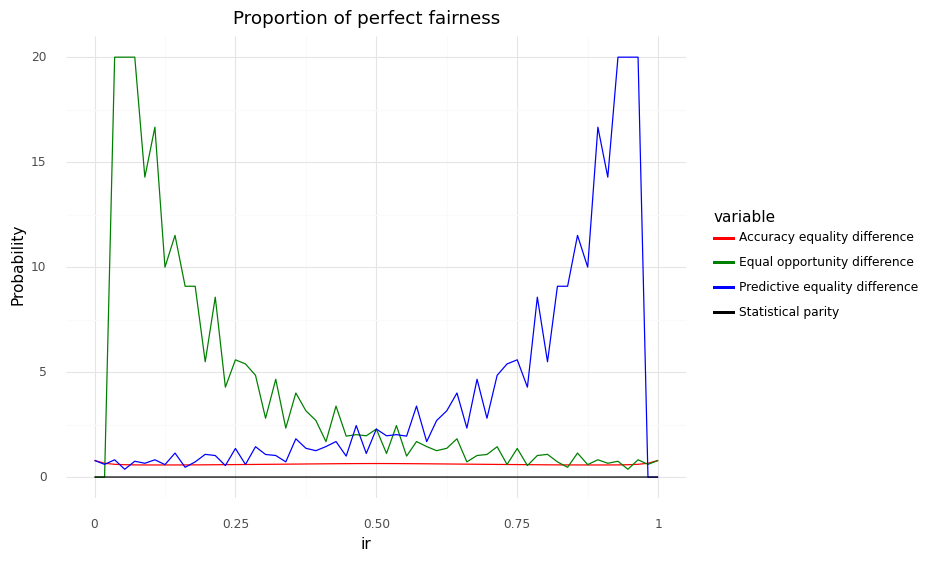

In [25]:
drop1 = ['Negative predictive parity difference', 'Positive predictive parity difference']
fig = plot_sonya(melt_sonya(df.copy().drop(drop1, axis=1), base_metric), base_metric)
fig.save(plotsDir + "sonya_" + base_metric + "2.jpeg", width = 8, height = 6, dpi = 300)

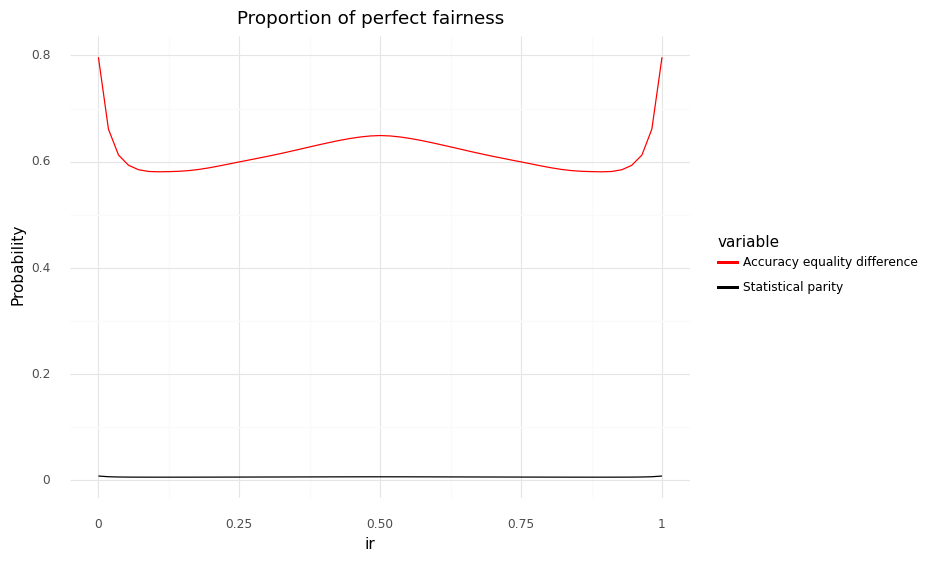

In [26]:
drop2 = drop1 + ['Equal opportunity difference', 'Predictive equality difference']
fig = plot_sonya(melt_sonya(df.copy().drop(drop2, axis=1), base_metric), base_metric)
fig.save(plotsDir + "sonya_" + base_metric + "3.jpeg", width = 8, height = 6, dpi = 300)